In [1]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import numpy as np
import cv2
from PIL import Image
import os
%env SCIPY_ARRAY_API=1
from sklearn.linear_model import Ridge
import naplib as nl
from naplib.visualization import strf_plot
import thesis
import yaml

env: SCIPY_ARRAY_API=1


In [2]:
# thesis.utils.convert_to_npy("response")

In [3]:
raw_response = thesis.load_data.load_response()
raw_stimulus = thesis.load_data.load_stimulus()
height, width = int(raw_response.shape[2]), int(raw_response.shape[3])

Adding data/mouse219/R25/response_mouse219_R25.npy...


This file contains 30 trials
Adding data/mouse221/R10/response_mouse221_R10.npy...
This file contains 20 trials
Adding data/mouse220/R26/response_mouse220_R26.npy...
This file contains 20 trials
Adding data/mouse220/R14/response_mouse220_R14.npy...
This file contains 20 trials


[0.0000e+00 4.0000e-06 8.0000e-06 ... 4.9988e-02 4.9992e-02 4.9996e-02]


In [4]:
from math import gcd

code_params = {
    "block_size": gcd(width, height),
    "strf_fit_dtype": np.float64,
    "strf_fit_batch_size": 10,
    "sr_audio": 250000,
    "sr_response": 100,
    "max_lag": 0.3,
    "end_stim": 37500 / 250000,
    "max_epochs": 150,
    "reduce_data": False,
}
code_params["nr_trials"] = raw_response.shape[0]
code_params["block_size"] = (10, 10)
code_params["strf_fit_dtype"] = np.float16

In [5]:
# # make movie
# frame_size = test_data.shape[1:3]

# out_lossless = cv2.VideoWriter('test_video.mkv',cv2.VideoWriter_fourcc(*'FFV1'), 100, (frame_size[1], frame_size[0]))
# out_lossy = cv2.VideoWriter('test_video_lossy.mkv',cv2.VideoWriter_fourcc(*'VP90'), 100, (frame_size[1], frame_size[0]))

# cm_test_data = np.copy(test_data)

# bwr_cm = cm.get_cmap('bwr')
# cm_test_data = bwr_cm((test_data - np.min(test_data)) / (np.max(test_data) - np.min(test_data)))

# cm_test_data = (cm_test_data[:, :, :, :3]*255).astype(np.uint8)

# example_images = 100, 250, 400

# for index, frame in enumerate(cm_test_data):
#     if index in example_images:
#         cv2.imwrite(f"images/frame_{index}.png", frame)
#     out_lossless.write(frame)
#     out_lossy.write(frame)
# out_lossless.release()
# out_lossy.release()

In [9]:
response = raw_response
stimulus = raw_stimulus
if code_params["reduce_data"]:
    small_response = thesis.preprocessing.smallify_response(
        response, code_params["block_size"]
    )
else:
    small_response = response

print(small_response.shape)

small_height, small_width = small_response.shape[2], small_response.shape[3]
code_params["prep_resp_dims"] = [small_height, small_width]
small_response = small_response.reshape(
    small_response.shape[0], small_response.shape[1], -1
)
thesis.thesis_logger.logger.debug(
    f"Frame dimensions are {small_height}, {small_width}."
)

Frame dimensions are 170, 152.


(90, 420, 170, 152)


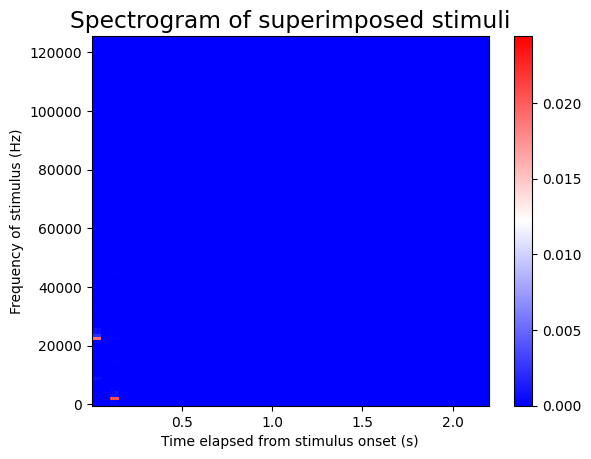

In [10]:
import scipy as sp
from sklearn.preprocessing import StandardScaler

# clip response to stimulus start and normalize
# = MinMaxScaler()
f, t, Sxx = sp.signal.spectrogram(np.sum(stimulus, axis=0), fs=code_params["sr_audio"])
plt.pcolormesh(t, f, Sxx, cmap="bwr")
plt.colorbar()
plt.rcParams.update({"font.size": 14})
plt.title("Spectrogram of superimposed stimuli")
plt.xlabel("Time elapsed from stimulus onset (s)")
plt.ylabel("Frequency of stimulus (Hz)")
plt.show()

In [11]:
spec = thesis.generate.generate_spectrogram(
    stimulus, response, sr_audio=code_params["sr_response"]
)

In [12]:
### data naming
code_params["crossval"] = False
code_params["jackknife"] = False
res = f"{small_height}x{small_width}"

desc_param = (
    ("jack" if code_params["jackknife"] else "")
    + ("CV" if code_params["crossval"] else "")
    + ("reduced" if code_params["reduce_data"] else "")
    + res
    + f"_{code_params['nr_trials']}_trials"
)
code_params["output_prefix"] = f"output/{desc_param}"

with open("prep_response.npy", "wb") as f:
    np.save(f, small_response)
with open("prep_spec.npy", "wb") as f:
    np.save(f, spec)

with open("code_params.yaml", "w") as file:
    yaml.dump(code_params, file)